# Week One Final Project: Movie Revenue Prediction and Exploration

Where has week one gone! We have one more project for you to put a nice little bow on all of the hard work you've done so far. For this project, be persistent, be curious, and ask questions if you get stuck!

## The Project

You and your teammates will create one prediction model and *AT LEAST* three plots or charts. Everyone will present their model and their charts during the final session of the day.
* Model predictions will be ranked according to their r-squared values and we will crown a winner!
* Your plots should be driven by curiosity. Everyone will present at least one plot.

## Helper Functions

We've provided helper functions down below. If you need help remembering what they do, refer to the `airbnb_solution.ipynb` example.

In [1]:
# We'll use these packages
import pandas as pd
import numpy as np
import ast
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer

pd.set_option('display.max_columns', 100)

# Read in the data!
movie_data = pd.read_csv("movie_dataset_final.csv")

In [3]:
movie_data.head()

,movieId,ratings_mean,ratings_count,ratings_std,imdbId,tmdbId,adult,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,genres_list,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,ScienceFiction,TVMovie,Thriller,War,Western
0,1,3.872470,247,0.958981,114709,862.0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862.0,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[Animation, Comedy, Family]",0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,2,3.401869,107,0.880714,113497,8844.0,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844.0,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[Adventure, Fantasy, Family]",0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2,3,3.161017,59,1.150115,113228,15602.0,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602.0,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[Romance, Comedy]",0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,4,2.384615,13,0.938835,114885,31357.0,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357.0,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[Comedy, Drama, Romance]",0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,5,3.267857,56,0.948512,113041,11862.0,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862.0,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",[Comedy],0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
# Helper Function: Feature Engineering
# Use this to turn dictionary columns into useful features
# We use the genre column as an example

column = "genres"  # FEEL FREE TO CHANGE THIS
number_to_keep = 100

def process_col_name(col_name):
    col_name_list = ast.literal_eval(col_name)
    if not isinstance(col_name_list, list):
        return []
    return [dic['name'] for dic in col_name_list if isinstance(dic, dict) and 'name' in dic]

movie_data[f'{column}_list'] = movie_data[column].apply(process_col_name)

# Compute the frequency of each col_name member
freq = pd.Series([name for sublist in movie_data[f'{column}_list'].tolist() for name in sublist]).value_counts()

# Keep the top 100 most frequent col_name members
top_col_name = freq[:number_to_keep].index.tolist()

# Filter the lists in the column to only include top col_name members
movie_data[f'{column}_list'] = movie_data[f'{column}_list'].apply(lambda x: [i for i in x if i in top_col_name])

mlb = MultiLabelBinarizer()

binary_matrix = pd.DataFrame(mlb.fit_transform(movie_data[f'{column}_list']), columns=mlb.classes_)

# Clean the column names: keep only alphanumeric characters and underscores
binary_matrix.columns = binary_matrix.columns.str.replace('[^0-9a-zA-Z_]', '', regex=True)

# Now, concatenate the binary matrix with the original DataFrame
new_feature_names = binary_matrix.columns
movie_data = pd.concat([movie_data, binary_matrix], axis=1)

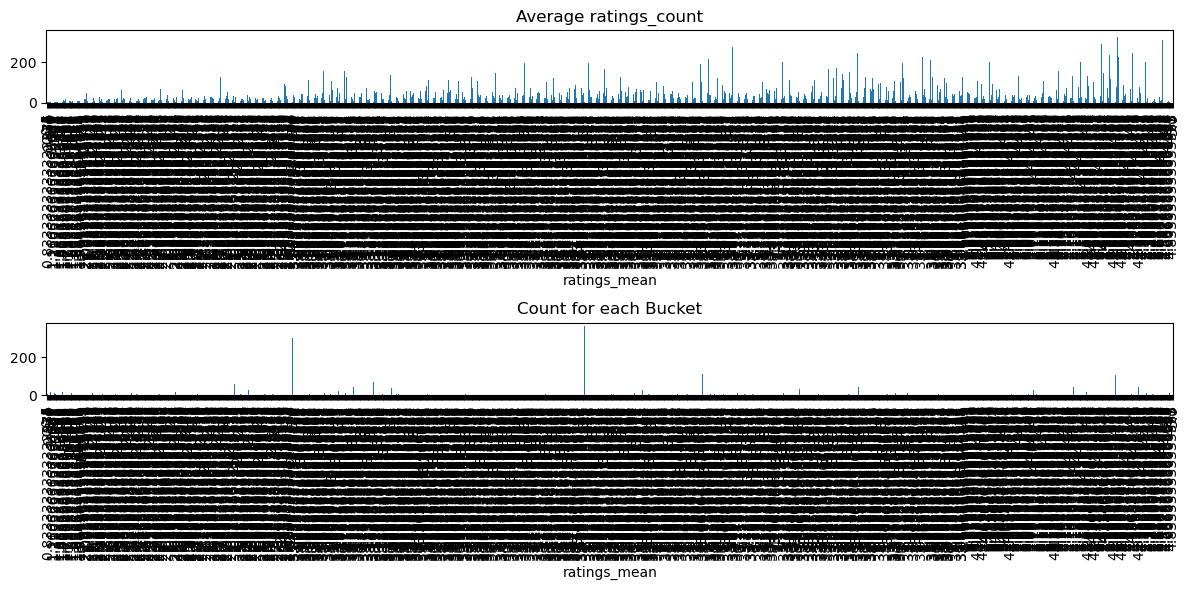

In [6]:
# Helper Function: Two Bar Chart Plots
groupby_variable = "ratings_mean"
y_value = "ratings_count"

fig, axs = plt.subplots(2, 1, figsize=(12, 6))
movie_data.groupby(groupby_variable)[y_value].mean().plot(kind="bar", ax=axs[0], title=f"Average {y_value}")
movie_data.groupby(groupby_variable)[y_value].count().plot(kind="bar", ax=axs[1], title=f"Count for each Bucket")
fig.tight_layout()

<Axes: xlabel='ratings_mean', ylabel='original_language'>

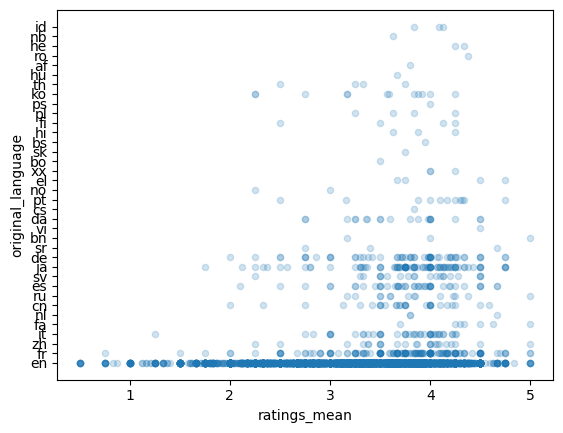

In [7]:
# Helper Function: Scatter Plotraing

x_value = "ratings_mean"
y_value = "original_language"

movie_data.plot(x=x_value, y=y_value, kind="scatter", alpha=0.2)

Training Data Statistics
mean_absolute_error:  71464885.30862713
mean_squared_error 1.9447848036928124e+16
R**2 0.16276431036978356

Validation Data Statistics
mean_absolute_error:  74052195.25687066
mean_squared_error 2.2137399884480844e+16
R**2 0.1340432920803486


C:\Users\chtva\AppData\Local\Temp\ipykernel_37660\3056423537.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[f"predicted_{target}"] = model.predict(train_data[features])
C:\Users\chtva\AppData\Local\Temp\ipykernel_37660\3056423537.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data[f"predicted_{target}"] = model.predict(validation_data[features])


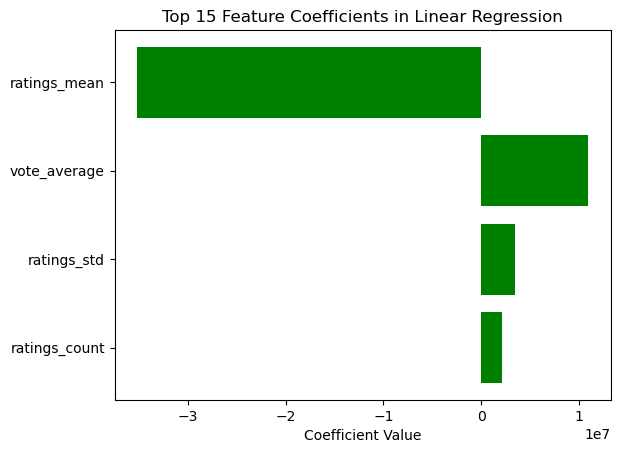

In [15]:
# Helper Function: Model Training
features = ["ratings_std", "vote_average", "ratings_mean", "ratings_count"]

target = "revenue"  # LEAVE THIS ALONE
model_type = "linear regression"  # Options: "random forest" or "linear regression"
features_to_show = 15


if model_type == "random forest":
    model = RandomForestRegressor()
elif model_type == "linear regression":
    model = LinearRegression()

shuffled_data = movie_data.sample(len(movie_data))  # Shuffle our data
train_data = shuffled_data[:int(len(shuffled_data)*0.8)]
validation_data = shuffled_data[int(len(shuffled_data)*0.8):]

model.fit(train_data[features], train_data[target])

train_data[f"predicted_{target}"] = model.predict(train_data[features])
validation_data[f"predicted_{target}"] = model.predict(validation_data[features])

# How do we measure our success?
print("Training Data Statistics")
print("mean_absolute_error: ", mean_absolute_error(train_data[target], train_data[f"predicted_{target}"]))
print("mean_squared_error", mean_squared_error(train_data[target], train_data[f"predicted_{target}"]))
print("R**2", r2_score(train_data[target], train_data[f"predicted_{target}"]))
print("")

print("Validation Data Statistics")
print("mean_absolute_error: ", mean_absolute_error(validation_data[target], validation_data[f"predicted_{target}"]))
print("mean_squared_error", mean_squared_error(validation_data[target], validation_data[f"predicted_{target}"]))
print("R**2", r2_score(validation_data[target], validation_data[f"predicted_{target}"]))

if model_type == "random forest":
    importances = model.feature_importances_
    indices = np.argsort(importances)[-features_to_show:]  # sort top features

    # Create a figure and a set of subplots
    fig, ax = plt.subplots()

    # Bar plot
    ax.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.title(f'Top {features_to_show} Feature Importances')
    plt.show()

if model_type == "linear regression":
    coefficients = model.coef_
    indices = np.argsort(np.abs(coefficients))[-features_to_show:]  # sort top features by magnitude

    # Create a figure and a set of subplots
    fig, ax = plt.subplots()

    # Bar plot
    ax.barh(range(len(indices)), coefficients[indices], color='g', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Coefficient Value')
    plt.title(f'Top {features_to_show} Feature Coefficients in Linear Regression')
    plt.show()